In [32]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from transformers import get_cosine_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup

In [10]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.head = nn.Linear(3, 1)
    
    def forward(self, x):
        return x

In [11]:
model = Model()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)

In [51]:
import math

from torch.optim.lr_scheduler import LambdaLR


def get_cosine_with_hard_restarts_schedule_with_warmup(
    optimizer, num_warmup_steps: int, num_training_steps: int, num_cycles: int = 2, restart_ratio: float = 1.0, last_epoch: int = -1
):
    """
    Create a schedule with a learning rate that decreases following the values of the cosine function between the
    initial lr set in the optimizer to 0, with several hard restarts, after a warmup period during which it increases
    linearly between 0 and the initial lr set in the optimizer.
    Args:
        optimizer ([`~torch.optim.Optimizer`]):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (`int`):
            The number of steps for the warmup phase.
        num_training_steps (`int`):
            The total number of training steps.
        num_cycles (`int`, *optional*, defaults to 1):
            The number of hard restarts to use.
        last_epoch (`int`, *optional*, defaults to -1):
            The index of the last epoch when resuming training.
    Return:
        `torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """
    num_cycles = 2
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        if progress >= 1.0:
            return 0.0
        if progress < 0.5:
            return max(0.0, 0.5 * (1.0 + math.cos(math.pi * ((float(num_cycles) * progress) % 1.0))))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * ((float(num_cycles) * progress) % 1.0)))) * restart_ratio

    return LambdaLR(optimizer, lr_lambda, last_epoch)

In [52]:
num_warmup_steps = 200
num_training_steps = 1000
# scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps, num_cycles=0.5)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=500, T_mult=1)
scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, 0, num_training_steps, restart_ratio=0.2)

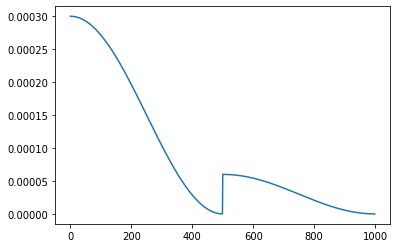

In [53]:
lrs = []
for i in range(num_training_steps):
    lrs.append(scheduler.get_last_lr())
    scheduler.step()
plt.plot(range(num_training_steps), lrs)
plt.show()